In [1]:
# ===============================
# Librairies
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from keras import layers, models, callbacks, optimizers, losses, metrics

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# ===============================
# Load a real time series
# ===============================
def load_data_from_csv(filepath):
    # Load CSV without header
    df = pd.read_csv(filepath, header=None)
    # Combine first two rows into a single header
    header1 = df.iloc[0].fillna("")  # market symbols
    header2 = df.iloc[1].fillna("")  # OHLCV etc
    # Create new column names
    new_header = []
    for h1, h2 in zip(header1, header2):
        if h1 != "":
            new_header.append(f"{h1}_{h2}" if h2 != "" else h1)
        else:
            new_header.append(h2)
    # Drop first two rows from the data
    df = df[2:]
    df.columns = new_header
    df = df.reset_index(drop=True)
    # Optional: remove fully empty columns
    df = df.dropna(axis=1, how='all')
    return df

df_load = load_data_from_csv("../data/Stock_Market_Initial_Data.csv")

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_56007/3616535248.py:6: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,64,65,66,67,68,69,71,72,73,74,75,76,78,79,80,81,82,83,85,86,87,88,89,90,92,93,94,95,96,97,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,141,142,143,144,145,146,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,165,166,167,169,170,171,172,173,174,176,177,178,179,180,181,183,184,185,186,187,188,190,191,192,193,194,195,197,198,199,200,201,202,204,205,206,207,208,209,211,212,213,214,215,216,218,219,220,221,222,223,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None)


In [3]:
# ===============================
# Function to extract market data for a specific index from the CSV file
# ===============================
def extract_market_data(df, market_name):
    """
    Extract Date + OHLCV columns for a given market
    """
    df.columns = df.columns.str.strip()
    high_col_candidates = [c for c in df.columns if c.startswith(f"{market_name}_High")]
    if not high_col_candidates:
        raise ValueError(f"Column starting with {market_name}_High not found.")
    
    high_col = high_col_candidates[0]
    high_idx = df.columns.get_loc(high_col)
    
    # Date + next 6 columns (High, Low, Open, Close, Volume, Adj Close)
    cols_idx = [0] + list(range(high_idx, high_idx + 6))
    df_market = df.iloc[:, cols_idx].copy()
    df_market = df_market.reset_index(drop=True)
    
    # Rename columns for clarity
    df_market.columns = ["Date", "High", "Low", "Open", "Close", "Volume", "Adj Close"]
    df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]] = df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]].astype(float)
    return df_market

# Example for ^GSPC
df_gspc = extract_market_data(df_load, "^GSPC")

In [4]:
# ===============================
# Preprocess the data to add additional informations
# ===============================
def preprocess_data(df):
    """
    Full preprocessing for OHLCV financial data
    Adds trend, momentum, volatility, OHLC-based, volume, and temporal features
    """

    # 1. Temporal features (not useful for stock market datas)
    # dates = pd.to_datetime(df['Date'])
    # df['DayOfYear'] = dates.dt.dayofyear
    # df['Month'] = dates.dt.month
    # df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    # df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
    # df['Sin_Month'] = np.sin(2 * np.pi * df['Month'] / 12)
    # df['Cos_Month'] = np.cos(2 * np.pi * df['Month'] / 12)

    # 2. Price-based indicators
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

    # Momentum / Returns
    df['Daily_Return'] = df['Close'].pct_change()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Momentum_4'] = df['Close'] - df['Close'].shift(4)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    # Relative Strength / Momentum indicators
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    low14 = df['Close'].rolling(14).min()
    high14 = df['Close'].rolling(14).max()
    df['Stochastic_K'] = 100 * (df['Close'] - low14) / (high14 - low14)
    df['Stochastic_D'] = df['Stochastic_K'].rolling(3).mean()

    # Volatility indicators
    df['Volatility_10'] = df['Close'].rolling(10).std()
    df['Volatility_20'] = df['Close'].rolling(20).std()
    df['ATR_14'] = df['High'].combine(df['Close'].shift(1), max) - df['Low'].combine(df['Close'].shift(1), min)
    df['ATR_14'] = df['ATR_14'].rolling(14).mean()
    df['Price_Range'] = df['High'] - df['Low']

    # MACD
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['Middle_Band'] = df['Close'].rolling(20).mean()
    df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(20).std() * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(20).std() * 2)
    df['BB_%B'] = (df['Close'] - df['Lower_Band']) / (df['Upper_Band'] - df['Lower_Band'])
    
    # OHLC-based features
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Candle_Body'] = df['Close'] - df['Open']
    df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['HL_Ratio'] = df['High'] / df['Low']
    df['CO_Ratio'] = df['Close'] / df['Open']
    
    # Volume-based features
    df['Volume_SMA_20'] = df['Volume'].rolling(20).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(50).mean()
    df['Volume_Change'] = df['Volume'].pct_change() # clip?? 
    # Volume indicators
    obv = [0]
    for i in range(1, len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            obv.append(obv[-1] + df['Volume'][i])
        elif df['Close'][i] < df['Close'][i-1]:
            obv.append(obv[-1] - df['Volume'][i])
        else:
            obv.append(obv[-1])
    df['OBV'] = obv
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    
    # Drop NaNs created by rolling/shift
    df.dropna(inplace=True)
    
    return df

df = preprocess_data(df_gspc)

In [5]:
# ===============================
# Drop unused columns and verify data consistency
# ===============================
df_ml = df.copy()

df_ml = df_ml.drop(columns=["Date", "Adj Close"], errors="ignore")   # Remove non-numeric and useful column
df_ml = df_ml.select_dtypes(include=[np.number]).dropna()

In [6]:
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna()

In [7]:
# ===============================
# Keep historical data for later recursive forecast sequences recalculations
# ===============================
df_raw_hist = df_gspc[['High','Low','Open','Close','Volume']].copy()
df_raw_hist = df_raw_hist.select_dtypes(include=[np.number]).dropna()
df_raw_hist = df_raw_hist.replace([np.inf, -np.inf], np.nan)
df_raw_hist = df_raw_hist.dropna()
df_raw_hist.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
High,6310.0,1.811320e+03,9.372993e+02,695.270019,1.167902e+03,1.395890e+03,2.147167e+03,4.818620e+03
Low,6310.0,1.788631e+03,9.275350e+02,666.789978,1.150972e+03,1.375375e+03,2.130922e+03,4.780040e+03
Open,6310.0,1.800414e+03,9.326635e+02,679.280029,1.161058e+03,1.386485e+03,2.139150e+03,4.804510e+03
Close,6310.0,1.800652e+03,9.326594e+02,676.530029,1.161088e+03,1.386920e+03,2.139175e+03,4.796560e+03
Volume,6310.0,3.014382e+09,1.597637e+09,0.000000,1.493925e+09,3.203995e+09,3.953060e+09,1.145623e+10


In [8]:
# ===============================
# Scale price datas not to cause imbalance into the model
# ===============================
# 1. Volume columns
volume_cols = ["Volume", "Volume_SMA_20", "Volume_SMA_50", "Volume_Change", "OBV"]
volumes_scaler = RobustScaler()
df_ml[volume_cols] = volumes_scaler.fit_transform(df_ml[volume_cols])

# 2. Price columns
price_cols = [
    "High", "Low", "Open", # "Adj Close",
    "SMA_50", "SMA_200", "EMA_20", "EMA_50",
    "Middle_Band", "Upper_Band", "Lower_Band",
    "Typical_Price", "VWAP"
]
prices_scaler = RobustScaler()
df_ml[price_cols] = prices_scaler.fit_transform(df_ml[price_cols])

indicators_scalers = {}
indicators_cols = [
  'Daily_Return', 'Log_Return', 'Momentum_4', 'Momentum_10', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
    'Volatility_10', 'Volatility_20', 'ATR_14', 'Price_Range', 
    'MACD', 'MACD_Signal', 'BB_%B',
    'Candle_Body', 'Upper_Shadow', 'Lower_Shadow', 'Gap',
    'HL_Ratio', 'CO_Ratio'
]
for col in indicators_cols:
    indicators_scalers[col] = RobustScaler()
    df_ml[col] = indicators_scalers[col].fit_transform(df_ml[[col]])

close_scaler = RobustScaler()
df_ml["Close"] = close_scaler.fit_transform(df_ml[["Close"]])

In [9]:
# ===============================
# Removing those that contains the same information
# ===============================
df_ml = df_ml.drop(columns=['High', 'Low', 'Open', 
                            'SMA_200', 'EMA_50',
                            'Price_Range', 'Volatility_20',
                            'MACD',
                            'Middle_Band', 'Lower_Band', 
                            'Typical_Price', 
                            'Volume_SMA_20', 'VWAP'
                            ])

In [10]:
# ===============================
# Some hyperparameters for model training 
# ===============================
SEQ_LEN = 60           # input window (days)
PRED_HORIZON = 1       # predict 1 step ahead (next day), for multi-step, see recursive forecast
BATCH_SIZE = 64
EPOCHS = 10
VAL_SIZE = 0.1         # fraction for validation (time split used below)
TEST_SIZE = 0.1        # fraction for test (time split used below)

In [11]:
# ===============================
# Define features and targets
# ===============================
# Required inputs (assumptions)
FEATURE_COLS = ['Close', 
                'SMA_50', 'EMA_20', 
                'Daily_Return', 'Log_Return', 'Momentum_4', 'Momentum_10',
                'RSI_14', 'Stochastic_K', 'Stochastic_D', 
                'Volatility_10', 'ATR_14', 
                'MACD_Signal',
                'Upper_Band', 'BB_%B', 
                'Candle_Body', 'Upper_Shadow', 'Lower_Shadow', 'Gap', 'HL_Ratio', 'CO_Ratio', 
                'Volume_SMA_50', 'Volume_Change', 'OBV'
              ]
TARGET_COL = "Close"  # the model will predict this (1-step ahead)

In [12]:
# ===============================
# Build sequences
# ===============================
def build_sequences(df, feature_cols, target_col, seq_len=SEQ_LEN, pred_horizon=1):
    """
    Build X, y arrays for supervised learning.
    X shape: (N_samples, seq_len, n_features)
    y shape: (N_samples, pred_horizon)  # pred_horizon=1 gives (N,1)
    """
    data = df[feature_cols].to_numpy()
    target = df[target_col].to_numpy()

    N = len(df)
    X, y = [], []
    last_start = N - seq_len - pred_horizon + 1
    if last_start <= 0:
        raise ValueError("Not enough rows to build sequences. Reduce seq_len or pred_horizo")
    for i in range(last_start):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len : i+seq_len+pred_horizon])
    X = np.array(X)
    y = np.array(y)
    # If pred_horizon==1, allow shape (N,) or (N,1) depending on downstream code. We'll keep (N, pred_horizon)
    return X, y

# Build sequences
X, y = build_sequences(df_ml, FEATURE_COLS, TARGET_COL, seq_len=SEQ_LEN, pred_horizon=PRED_HORIZON)
print("X.shape, y.shape =", X.shape, y.shape)

X.shape, y.shape = (6249, 60, 24) (6249, 1)


In [13]:
# ===============================
# Train/validation (time-ordered)
# ===============================
# Keep time ordering: first 80% train, 10% validation, last 10% test
n_samples = X.shape[0]
train_end = int((1 - VAL_SIZE - TEST_SIZE) * n_samples)
val_end = int((1 - TEST_SIZE) * n_samples)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

print("Train samples:", X_train.shape, "Val samples:", X_val.shape[0], "Test samples:", X_test.shape[0])

Train samples: (4999, 60, 24) Val samples: 625 Test samples: 625


In [14]:
# ===============================
# Model definition (stacked LSTM)
# ===============================
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        # Always active during inference
        return super().call(inputs, training=True)
    
def build_stack_lstm_mc_dropout(seq_len, n_features, d_model=64, dropout=0.1):
    inp = layers.Input(shape=(seq_len, n_features))

    # First block
    x = layers.LSTM(d_model, return_sequences=True)(inp)
    x = layers.LayerNormalization()(x)
    x = MCDropout(dropout)(x)

    # Second block
    x = layers.LSTM(d_model, return_sequences=True)(x)
    x = layers.LayerNormalization()(x)
    x = MCDropout(dropout)(x)

    # Temporal Attention
    attn = layers.Attention()([x, x])
    x = layers.GlobalAveragePooling1D()(attn)

    # Dense head
    x = layers.Dense(128, activation="relu")(x)
    x = MCDropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)

    out = layers.Dense(PRED_HORIZON, activation="linear")(x)

    model = models.Model(inp, out)
    return model

n_features = X.shape[2]
model = build_stack_lstm_mc_dropout(SEQ_LEN, n_features, d_model=64, dropout=0.1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 60, 64)    │     22,784 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ lstm[0][0]        │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout          │ (None, 60, 64)    │          0 │ layer_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 60, 64)    │     33,024 │ mc_dropout[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ lstm_1[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_1        │ (None, 60, 64)    │          0 │ layer_normalizat… │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 64)    │          0 │ mc_dropout_1[0][… │
│ (Attention)         │                   │            │ mc_dropout_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mc_dropout_2        │ (None, 128)       │          0 │ dense[0][0]       │
│ (MCDropout)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ mc_dropout_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72,705 (284.00 KB)

 Trainable params: 72,705 (284.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ===============================
# Loss, optimizer, metrics and callbacks
# ===============================
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
opt = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=opt, loss="mse", metrics=["mae", rmse])
earlystop_cb = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_cb = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

In [18]:
# ===============================
# Training
# ===============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=[earlystop_cb, reduce_cb]
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.4647 - mae: 0.5110 - rmse: 0.5863 - val_loss: 0.2747 - val_mae: 0.4399 - val_rmse: 0.5107 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2192 - mae: 0.3720 - rmse: 0.4373 - val_loss: 0.1606 - val_mae: 0.3193 - val_rmse: 0.3890 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1141 - mae: 0.2646 - rmse: 0.3267 - val_loss: 0.1218 - val_mae: 0.2722 - val_rmse: 0.3387 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1243 - mae: 0.2743 - rmse: 0.3319 - val_loss: 0.3835 - val_mae: 0.5489 - val_rmse: 0.6071 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1079 - mae: 0.2590 - rmse: 0.3112 - val_loss: 0.1733 - val_mae: 0.3347 - val_rmse: 0.3972 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1726 - mae: 0.3266 - rmse: 0.3845 - val_loss: 0.1380 - val_mae: 

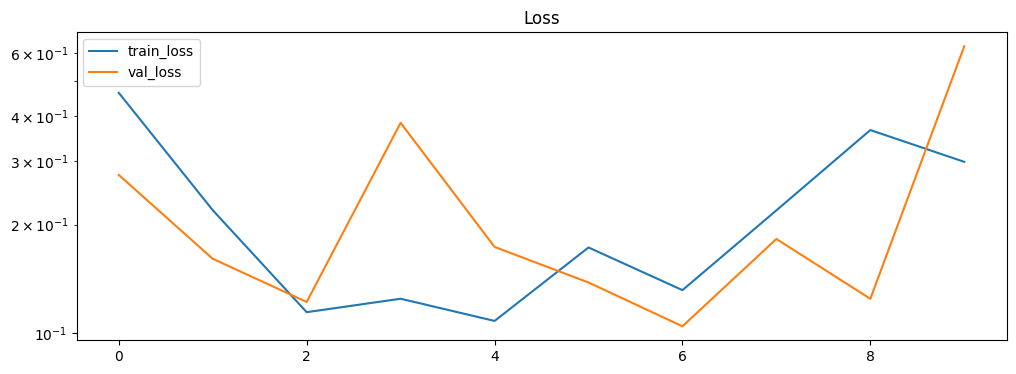

In [19]:
# ===============================
# Plot training loss & metrics
# ===============================
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.yscale("log")
plt.legend(); plt.title("Loss"); plt.show()

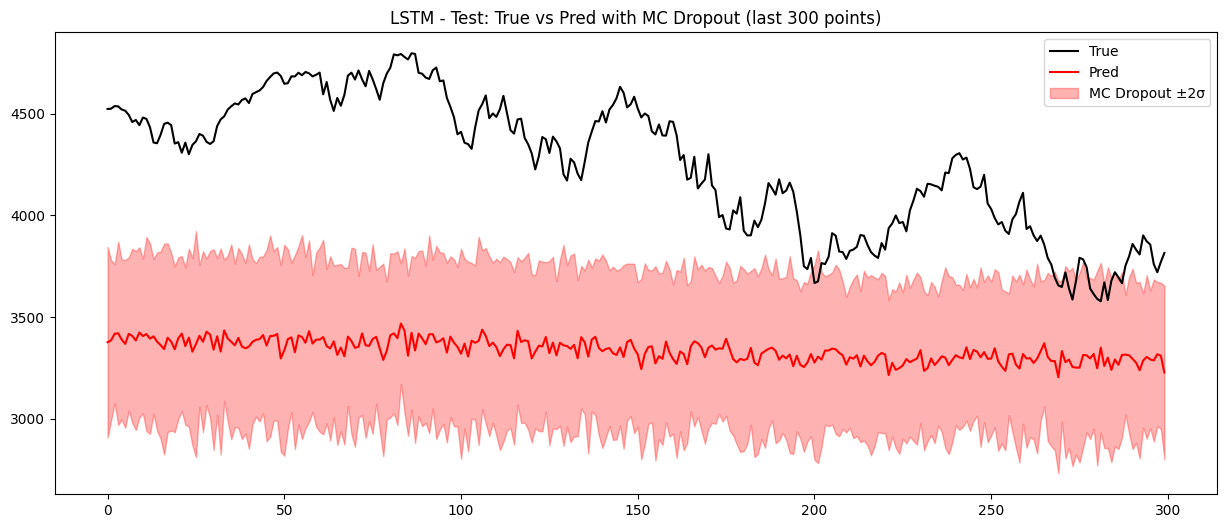

In [22]:
# ===============================
# Evaluate / Predictions (test)
# ===============================
T = 50  # number of MC samples
y_test_preds_mc = []

# Run MC Dropout inference
for _ in range(T):
    # training=True keeps dropout active
    y_pred_scaled = model(X_test, training=True).numpy()
    y_test_preds_mc.append(y_pred_scaled)

y_test_preds_mc = np.stack(y_test_preds_mc, axis=0)  # shape: (T, N_test, PRED_HORIZON)

# Mean prediction
y_test_pred_scaled_mean = y_test_preds_mc.mean(axis=0)
# Uncertainty (std)
y_test_pred_scaled_std = y_test_preds_mc.std(axis=0)

# Inverse scale to original prices
try:
    # Reshape for scaler
    y_pred_flat = y_test_pred_scaled_mean.reshape(-1, 1)
    y_pred_std_flat = y_test_pred_scaled_std.reshape(-1, 1)

    y_test_pred = close_scaler.inverse_transform(y_pred_flat).flatten()
    y_test_pred_std = close_scaler.inverse_transform(y_pred_flat + y_pred_std_flat).flatten() - y_test_pred
    y_test_true = close_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
except NameError:
    print("No target scaler found, keeping scaled values")
    y_test_pred = y_test_pred_scaled_mean.flatten()
    y_test_pred_std = y_test_pred_scaled_std.flatten()
    y_test_true = y_test.flatten()

# Plot true vs predicted with uncertainty bands
Nplot = min(300, len(y_test_true))
plt.figure(figsize=(15,6))
plt.plot(y_test_true[-Nplot:], label="True", color="black")
plt.plot(y_test_pred[-Nplot:], label="Pred", color="red")

# Plot ±2 sigma band for uncertainty
plt.fill_between(
    np.arange(Nplot),
    y_test_pred[-Nplot:] - 2*y_test_pred_std[-Nplot:],
    y_test_pred[-Nplot:] + 2*y_test_pred_std[-Nplot:],
    color='red', alpha=0.3, label="MC Dropout ±2σ"
)

plt.legend()
plt.title(f"LSTM - Test: True vs Pred with MC Dropout (last {Nplot} points)")
plt.show()

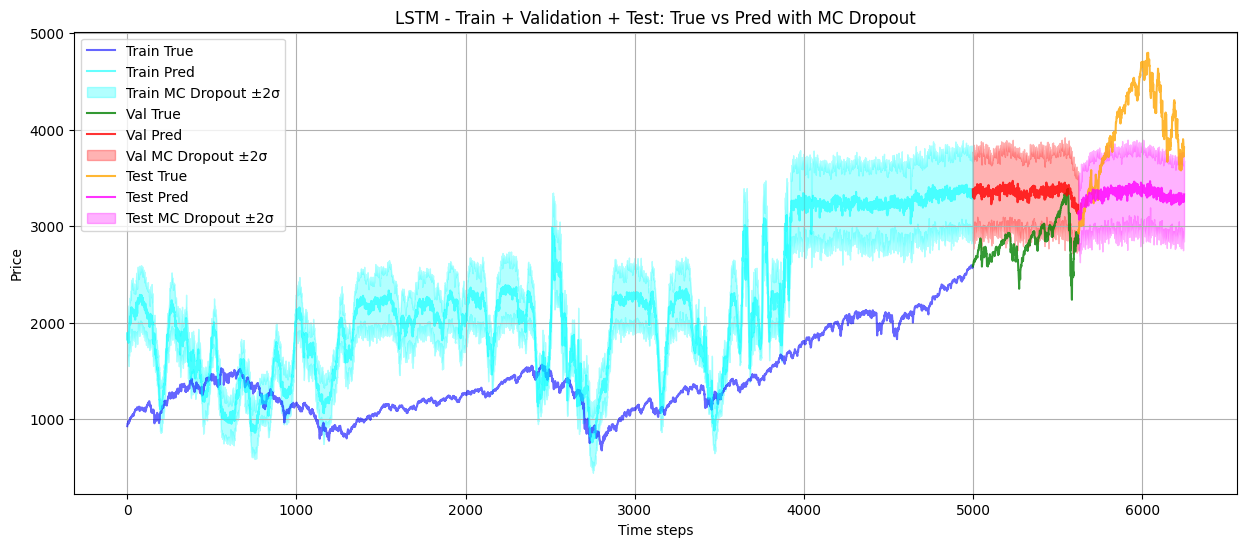

In [24]:
# ===============================
# Full series plot - Train + Validation + Test
# ===============================
T = 50  # number of MC samples

def mc_predict(model, X, scaler=None, T=50):
    """Run MC Dropout prediction"""
    preds_mc = []
    for _ in range(T):
        y_pred_scaled = model(X, training=True).numpy()
        preds_mc.append(y_pred_scaled)
    preds_mc = np.stack(preds_mc, axis=0)
    mean_scaled = preds_mc.mean(axis=0)
    std_scaled = preds_mc.std(axis=0)
    
    if scaler is not None:
        # Inverse scale
        mean_flat = mean_scaled.reshape(-1, 1)
        std_flat = std_scaled.reshape(-1, 1)
        mean_inv = scaler.inverse_transform(mean_flat).flatten()
        std_inv = scaler.inverse_transform(mean_flat + std_flat).flatten() - mean_inv
        return mean_inv, std_inv
    else:
        return mean_scaled.flatten(), std_scaled.flatten()

# MC predictions for train, val, test
y_train_pred, y_train_pred_std = mc_predict(model, X_train, scaler=close_scaler, T=T)
y_val_pred,   y_val_pred_std   = mc_predict(model, X_val, scaler=close_scaler, T=T)
y_test_pred,  y_test_pred_std  = mc_predict(model, X_test, scaler=close_scaler, T=T)

# Inverse scale true values if scaler exists
try:
    y_train_true = close_scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
    y_val_true   = close_scaler.inverse_transform(y_val.reshape(-1,1)).flatten()
    y_test_true  = close_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
except NameError:
    y_train_true, y_val_true, y_test_true = y_train.flatten(), y_val.flatten(), y_test.flatten()

# Plot true vs predicted with uncertainty bands for the whole serie 
plt.figure(figsize=(15,6))

plt.plot(y_train_true, label="Train True", color='blue', alpha=0.6)
plt.plot(y_train_pred, label="Train Pred", color='cyan', alpha=0.6)
plt.fill_between(
    np.arange(len(y_train_true)),
    y_train_pred - 2*y_train_pred_std,
    y_train_pred + 2*y_train_pred_std,
    color='cyan', alpha=0.3, label="Train MC Dropout ±2σ"
)
plt.plot(range(len(y_train_true), len(y_train_true)+len(y_val_true)), y_val_true, label="Val True", color='green', alpha=0.8)
plt.plot(range(len(y_train_true), len(y_train_true)+len(y_val_true)), y_val_pred, label="Val Pred", color='red', alpha=0.8)
plt.fill_between(
    np.arange(len(y_train_true), len(y_train_true)+len(y_val_true)),
    y_val_pred - 2*y_val_pred_std,
    y_val_pred + 2*y_val_pred_std,
    color='red', alpha=0.3, label="Val MC Dropout ±2σ"
)
plt.plot(range(len(y_train_true)+len(y_val_true), len(y_train_true)+len(y_val_true)+len(y_test_true)), y_test_true, label="Test True", color='orange', alpha=0.8)
plt.plot(range(len(y_train_true)+len(y_val_true), len(y_train_true)+len(y_val_true)+len(y_test_true)), y_test_pred, label="Test Pred", color='magenta', alpha=0.8)
plt.fill_between(
    np.arange(len(y_train_true)+len(y_val_true), len(y_train_true)+len(y_val_true)+len(y_test_true)),
    y_test_pred - 2*y_test_pred_std,
    y_test_pred + 2*y_test_pred_std,
    color='magenta', alpha=0.3, label="Test MC Dropout ±2σ"
)

plt.xlabel("Time steps")
plt.ylabel("Price")
plt.title(f"LSTM - Train + Validation + Test: True vs Pred with MC Dropout")
plt.legend()
plt.grid(True)
plt.show()